# Classificação

# MNIST

Este sera o dataset análisado, consiste em algorimos escritos a mão, o objetivo desse projeto será prever qual algorismo é este com base nos dados.

In [1]:
from sklearn.datasets import fetch_openml
#importando o dataset
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [17]:
#Separando as variaveis independentes e a variavel dependete
X, y = mnist["data"], mnist["target"].astype(np.uint8)
X.shape

(70000, 784)

Como podemos perceber, temos 70 mil observações e cada uma possui 784 características. pois são imagens de 28 x 28 pixels, como podemos visualizar pela imagem abaixo:

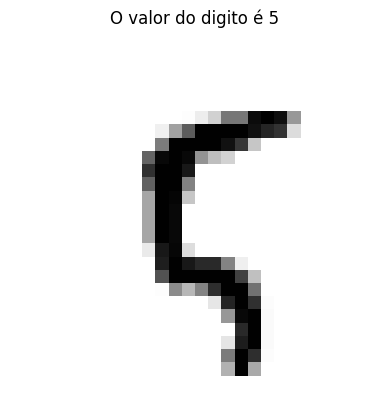

In [18]:
from matplotlib import pyplot as plt
import numpy as np

digito = np.array(X.iloc[100])
digito_imagem = digito.reshape(28, 28)

plt.imshow(digito_imagem, cmap='binary')
plt.title(f'O valor do digito é {y[100]}')
plt.axis('off')
plt.show()

In [20]:
from sklearn.model_selection import train_test_split as tts

X_train, X_test, y_train, y_test = tts(X, y, train_size = 0.857142857)

# Treinando um classificador binario

vamos começar simplificando o problema, classificando apenas se o númeor é um 5 ou não

In [21]:
# Criando um vetor com true para valores iguais a 5 e false, caso contrario
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [22]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)

SGDClassifier()

# Avaliando um modelo de classificação

Existem diversas formas de avaliar um modelo de classificação e algumas serão apresentadas a seguir

## Acuracia através da validação cruzada

Para isso utilizaremos a função presente no sklearn cross_val_score(), que divide o dataset em k_folds e treina modelos para predizer

In [23]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9624    , 0.9653    , 0.94934747])

Uma acuracia minima de 94% chama atenção, mas o dataset esta desbalenceado, com 10% das amostras sendo 5, assim caso o modelo chutasse tudo como não 5, teria uma acuracia de 90%

## Matriz de Confusão

Permite que tenhamos uma melhor ideia do desempenho do programa, assim podemos verificar os falsos positivos e falsos negativos. para fazer as predições utilizaremos o cross_val_predict(), que faz a mesma coisa que o cross_val_score(), mas retorna as predições através de validação cruzada ao invés das acuracias.

Para entendermos os resultados devemos entender que os valores na horizontal são os reais e os na vertical são os previstos, sendo assim a diagonal central mostra as predições corretas, e o canto superior direito é os falsos positivos e os canto inferior direito são os falsos positivos.

In [28]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

<AxesSubplot:>

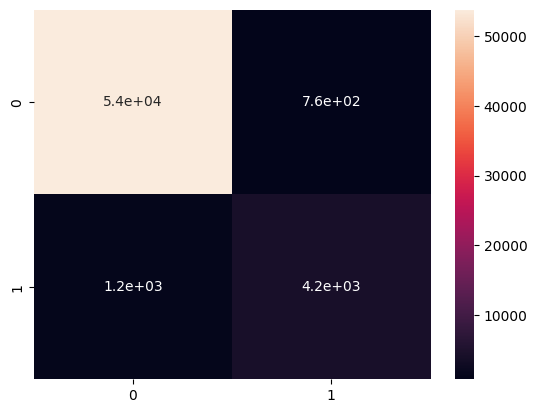

In [31]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

heatmap(confusion_matrix(y_train_5, y_train_pred), annot=True)

A partir das matrizes de confusão podemos tirar algumas outras métricas para a análise:

- Precisão: $\frac{TP}{TP+FP}$, com TP sendo o número de verdadeiros positivos e FP o número de falsos verdadeiros. Essa métrica pode ser burlada, caso haja apenas uma medida verdadeira, e ela esteja correta. Por isso essa medida é sempre apresentada em conjunto com a revocação.

- Revocação: $\frac{TP}{TP+FN}$, com FN sendo falso negativo, isso previne o caso descrito anteriormente, pois caso ele ocorra a revocação vai ser baixa, alertando para algo errado no modelo.

O scikir-learn oferece funções para calcularmos essas metricas de forma simples, como mostrado no código abaixo:

In [33]:
from sklearn.metrics import precision_score, recall_score

print(f'A precisão foi de {precision_score(y_train_5, y_train_pred)}')
print(f'A revocação foi de {recall_score(y_train_5, y_train_pred)}')

A precisão foi de 0.8455762987012987
A revocação foi de 0.7710954848260547


Ou seja, o preditor so acerta 84% quando diz que é um 5 e so detecta 77% dos 5. O resultado ja não parece tão bom.

Para fazer essa análise é importante que você considere as duas métricas e para isso existe o F1 score, que é a média harmônica da revocação e da precisão. Essa métrica é sensivel a valores baixos, com esses impactando muito o resultado, dando vantagem a valores altos. Também beneficia valores semelhante de precisão e revocação, algo que nem sempre é benéfico.
$$ F_1 = \frac{2}{\frac{1}{precisão}+\frac{1}{revocação}}$$

In [36]:
from sklearn.metrics import f1_score

print(f'O f1 foi de {f1_score(y_train_5, y_train_pred)}')

O f1 foi de 0.8066202090592335


### Trade-off precisão-revocação

Infelizmente, caso aumente a precisão a revocação cai, e vice versa. Isso acontece pois ele calcula um score e em uma funçao de decisão, caso esse score seja meno que o limiar ele retorna negativo e no inverso ele retorna positivo. Variando esse limiar é possivel alterar os valores de precisão e revocação. Podemos ver isso utilizando a precision_recal_curve() uma função do sklearn:

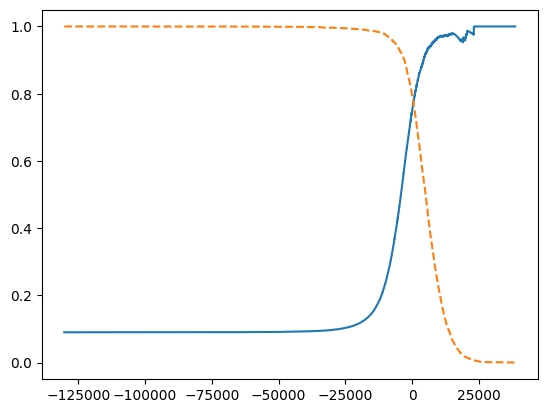

In [45]:
from sklearn.metrics import precision_recall_curve

#diferente dos das validações cruzadas anteriormente utilizamos o method para especificar que queremos os scores da funçao de decisão
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plt.plot(thresholds, precisions[:-1], '-', label='precisão')
plt.plot(thresholds, recalls[:-1], '--', label='revocação')
plt.show()